# MLP
MLP, K=5, epochs=200.
Use lncRNA.

Longest transcript per gene. Use GMM for threshold.

In [13]:
from datetime import datetime
print(datetime.now())

2023-04-04 14:13:13.484860


In [14]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
# tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
print(DATA_DIR)

GPU device not found
Running on CoLab
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [15]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=5
ALPHABET=4**K + 1
CFILTERS=64 
FILTERSIZE=8
RCELLS=32
DCELLS=16
EPOCHS=200 
EMBED_DIMEN = 4 # arbitrary hyperparameter
# MINLEN=200   # NO LONGER USED
MAXLEN=5000   
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'RCI_GMM'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
EXCLUSIONS = [1]   # possibly exclude cell line 1 = H1.hESC
FILTER_TRAIN        = False
FILTER_TAILS_TRAIN  = False
FILTER_MIDDLE_TRAIN = False
FILTER_TEST         = False
FILTER_TAILS_TEST   = False
FILTER_MIDDLE_TEST  = False

Python 3.9.16
sklearn 1.2.2


In [16]:
RCI_FILE_TRAIN = 'train.lncRNA_RCI.csv'
RCI_FILE_VALID = 'train.lncRNA_RCI.csv'
RCI_FILE_TEST  = None # else 'test.lncRNA_RCI.csv'

SEQ_FILE_TRAIN = 'train.longest_lncRNA_transcripts.csv'
SEQ_FILE_VALID = 'train.longest_lncRNA_transcripts.csv'
SEQ_FILE_TEST  = None # else 'test.longest_lncRNA_transcripts.csv'

In [17]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

## Data Load

In [18]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        self.gene2rci = dict()
        
    def load_gene_rci_values(self,filepath,exclusions):
        '''
        Load all the genes from the given RCI csv file.
        The given file usually contains train or test, not both.
        Load average RCI for each across cell lines.
        Define average as log of mean of antilogs: log2(mean(2^RCI)).
        Return dict with keys=gene:str and values=RCI:float.
        '''
        self.gene2rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    cell_line_index = 0
                    rci_values = []
                    log_mean=0.0
                    for rci_str in fields:
                        if cell_line_index not in exclusions:
                            if rci_str != "nan":
                                rci_val = float(rci_str)
                                rci_values.append(rci_val)
                        cell_line_index += 1
                    if len(rci_values)>0:
                        values = np.array(rci_values)
                        antilogs = [2**x for x in values]
                        big_mean = np.mean(antilogs)
                        if np.absolute(big_mean)<0.000001:
                            log_mean = -1000000 # neg infinity
                        else:
                            log_mean = np.log2(big_mean) 
                        self.gene2rci[gene_id] = log_mean
                    # TO DO: get rid of this check on our log/antilog arithmetic.
                    if len(rci_values)==1:
                        diff = rci_values[0]-log_mean
                        if diff>0.000001:
                            print('antilog',log_mean,'not equal',rci_values,'for gene',gene_id)
        print('Number of RCI values loaded',len(self.gene2rci.keys()))
        return self.gene2rci

    def _seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        '''
        Load all the sequences from the given file. 
        Load our version of GenCode -- csv, easier to parse than fasta.
        Each line has IDs plus sequence.
        The IDs in the file do not include dot-version numbers.
        The file may already be filtered e.g. canonical transcripts.
        '''
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # without version number
                    gene_id = fields[1]  # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    # Keep only transcripts having numeric RCI given the cell lines in use.
                    # We have validated this by spot checking.
                    # TO DO: validate this programmatically.
                    if gene_id in self.gene2rci.keys():
                        if seq_len<=MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                        seq_txt = seq_txt[:MAXLEN]
                        allids.append( (gene_id,tran_id) )
                        hot_vec = self._seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        self.cache=dict() # save RAM
        return allids,allseq

    def load_spectra(self,filepath):
        '''
        Load all (variable-length) sequences as lists of kmers.
        Then convert each sequence to (fixed-length) kmer histograms.
        '''
        allids,allseq = self.load_sequence(filepath)
        allspectra = []
        for seq in allseq:
            spectrum = np.zeros(ALPHABET)
            for kmer in seq:
                spectrum[kmer] += 1
            spectrum /= len(seq)
            allspectra.append(spectrum)
        return allids,allspectra        


## Model

In [19]:
def build_model():
    mlp    = Sequential()
    layer1 = Dense(64, activation='sigmoid',dtype=dt,input_dim=ALPHABET)
    layer2 = Dense(64, activation='sigmoid')
    layer3 = Dense(64, activation='sigmoid')
    output = Dense(1, activation='sigmoid')
    mlp.add(layer1)
    mlp.add(layer2)
    mlp.add(layer3)
    mlp.add(output)
      
    bc=BinaryCrossentropy(from_logits=False)
    mlp.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return mlp

In [20]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-04-04 14:13:14.607351
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_44 (Dense)            (None, 64)                65664     
                                                                 
 dense_45 (Dense)            (None, 64)                4160      
                                                                 
 dense_46 (Dense)            (None, 64)                4160      
                                                                 
 dense_47 (Dense)            (None, 1)                 65        
                                                                 
Total params: 74,049
Trainable params: 74,049
Non-trainable params: 0
_________________________________________________________________
None


## Training

In [21]:
import gc
class CrossValidator():
    def __init__(self,epochs,quick_test=False,score_threshold=0.5):
        self.epochs = epochs
        self.quick_test = quick_test
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = None
        self.flip = False
        self.reset_statistics()
        
    def reset_statistics(self):
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def _get_X_y(self, all_ids, all_seqs, rci_map, exclude_middle=False): 
        # Prepare X and y for training or testing.
        subsetX=[]
        subsetY=[]
        for t in range(len(all_ids)):
            gene_id,tran_id = all_ids[t]
            oneX            = all_seqs[t]
            oneY            = rci_map[gene_id]
            if exclude_middle and oneY >= -2 and oneY <= 0:
                # Exclude middle from train set only, for comparison to Yuan et al
                continue
            subsetX.append(oneX)
            subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values, create=True):
        if self.mechanism == 'RCI_GMM':
            if create:  # during training, create a new GMM
                gmm = GaussianMixture(n_components=2, verbose=0, 
                  covariance_type='spherical', n_init=100) # random_state=42) 
                gmm.fit(rci_values)
            else:   # during testing, use existing GMM
                gmm=self.discriminator
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm   # redundant but consistent
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = -1   # 0 usually, -1 is as in Yuan et al.
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def save_model(self,filename):
        if self.model is not None:
            self.model.save(filename)
        
    def load_model(self,filename):
        self.model = keras.models.load_model(filename)
        
    def train_new_model(self,train_ids,train_seq,train_rci,
            valid_ids=None,valid_seq=None,valid_rci=None):
        print(datetime.now())
        X_train,y_rci = self._get_X_y(train_ids,train_seq,train_rci) 
        self._prepare_threshold(y_rci,True)  
        self._explain_threshold()
        y_train = self._apply_threshold(y_rci)
        self._show_sizes('Train',y_train)
        cw = class_weight.compute_class_weight(
            'balanced', classes=[0,1], y=y_train)
        cwd = {0: cw[0], 1: cw[1]}
        print('Computed class weights:',cwd)
        if valid_ids is not None:
            X_valid,y_rci = self._get_X_y(valid_ids,valid_seq,valid_rci) 
            y_valid = self._apply_threshold(y_rci)
            self._show_sizes('Valid',y_valid)
        y_rci = None

        self.model=build_model()
        print("FIT")
        print(datetime.now())
        if valid_ids is None:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd) # no validation
        else:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd, 
            validation_data=(X_valid,y_valid) ) 

        if PRETTY_PICTURES:
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()
        
    def test_without_training(self,test_ids,test_seq,test_rci):
        # For final test, do no train.
        # Assume set_sequences() set the test set.
        print(datetime.now())
        X_test,y_rci = self._get_X_y(test_ids,test_seq,test_rci) 
        y_test = self._apply_threshold(y_rci)
        y_rci = None
        
        print("PREDICT")
        print(datetime.now())        
        yhat_pred=self.model.predict(X_test, verbose=0)     
        yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

        self._show_sizes('Test',y_test)
        self._show_sizes('Predict',yhat_classes)
        print('Test sizes',X_test.shape,y_test.shape)
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        print('Score threshold',self.score_threshold)
        cm1 = confusion_matrix(y_test,yhat_classes)
        print('Confusion matrix\n',cm1)
        cm2 = confusion_matrix(y_test,yhat_classes,normalize='all')
        print('Normalized matrix\n',cm2)

        accuracy = accuracy_score(y_test, yhat_classes)*100.
        precision = precision_score(y_test, yhat_classes)*100.
        recall = recall_score(y_test, yhat_classes)*100.
        f1 = f1_score(y_test, yhat_classes)*100.
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_test, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_test, yhat_pred)*100.
        mcc = matthews_corrcoef(y_test, yhat_classes)
        if PRETTY_PICTURES:
            self._pretty_pictures(y_test,yhat_pred,prc_X,prc_Y)
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.4f' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)

    def _pretty_pictures(self,y_valid,yhat_pred,prc_X,prc_Y):
        count_ones= len(y_valid[y_valid==1])
        count_zeros= len(y_valid[y_valid==0])
        guess = max(count_ones,count_zeros) / len(y_valid)
        # PRC
        plt.plot(prc_X, prc_Y, marker='.')
        plt.plot([0, 1], [guess,guess], linestyle='--')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        # ROC
        fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


## Train

In [22]:
class Separator():
    def __init__(self):
        self.train_ids = []
        self.train_seq = []
        self.train_rci = dict()
        self.val_ids = []
        self.val_seq = []
        self.val_rci = dict()
    def load(self,data_dir,rep,fold):
        filename='cv.{}.{}.validation_genes.txt'.format(rep,fold)
        filename = data_dir + filename
        self.val_genes = set()
        with open(filename,'r') as fin:
            for line in fin:
                gene_id = line.strip()
                self.val_genes.add(gene_id)
    def process(self,allids,allseq,gene_to_rci):
        size = len(allids)
        for t in range(size):
            gene_id,tran_id = allids[t]
            oneX            = allseq[t]
            oneY            = gene_to_rci[gene_id]
            in_middle = gene_to_rci[gene_id] >= -2 and gene_to_rci[gene_id] <= 0
            in_tails = gene_to_rci[gene_id] < -2 or gene_to_rci[gene_id] > 0
            if gene_id in self.val_genes:
                if not FILTER_TEST or \
                    (FILTER_TAILS_TEST and in_middle) or \
                    (FILTER_MIDDLE_TEST and in_tails):
                    self.val_ids.append(allids[t])
                    self.val_seq.append(allseq[t])
                    self.val_rci[gene_id]=gene_to_rci[gene_id]
            else:
                if not FILTER_TRAIN or \
                    (FILTER_TAILS_TRAIN and in_middle) or \
                    (FILTER_MIDDLE_TRAIN and in_tails):
                    self.train_ids.append(allids[t])
                    self.train_seq.append(allseq[t])
                    self.train_rci[gene_id]=gene_to_rci[gene_id]
    def get_ids(self):
        return self.train_ids,self.val_ids
    def get_seq(self):
        return self.train_seq,self.val_seq
    def get_rci(self):
        return self.train_rci,self.val_rci

2023-04-04 14:13:14.771413
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.csv
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.longest_lncRNA_transcripts.csv
Loaded 4369 sequences.
2023-04-04 14:13:28.241180

Training # 1 1
2023-04-04 14:13:28.242382
2023-04-04 14:13:28.242644
Discriminator is GMM
Means [-2.5130109773878346, -0.021984070700750723]
Variances [2.15414798 1.50516956]
Priors [0.42063182 0.57936818]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
Train 1:0 2153:1346 61.53%
Computed class weights: {0: 1.299777117384844, 1: 0.8125870877844867}
Valid 1:0 538:332 61.84%
FIT
2023-04-04 14:13:29.843117


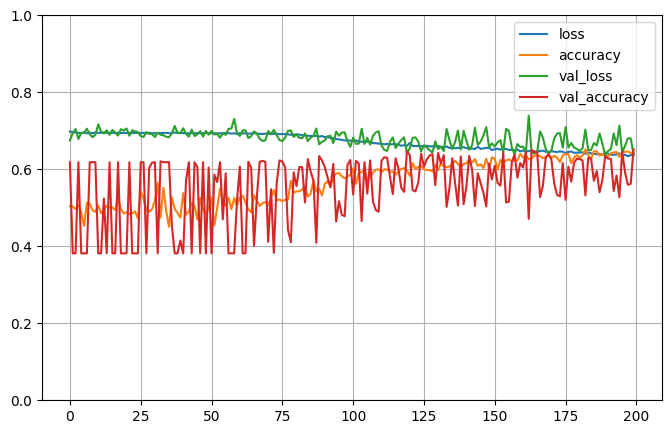


2023-04-04 14:14:52.664299

Testing # 1 1
2023-04-04 14:14:52.666457
2023-04-04 14:14:52.666520
PREDICT
2023-04-04 14:14:52.669965
Test 1:0 538:332 61.84%
Predict 1:0 675:195 77.59%
Test sizes (870, 1025) (870,)
Range of scores: 0.044863693 to 0.94414455
Score threshold 0.5
Confusion matrix
 [[112 220]
 [ 83 455]]
Normalized matrix
 [[0.12873563 0.25287356]
 [0.0954023  0.52298851]]


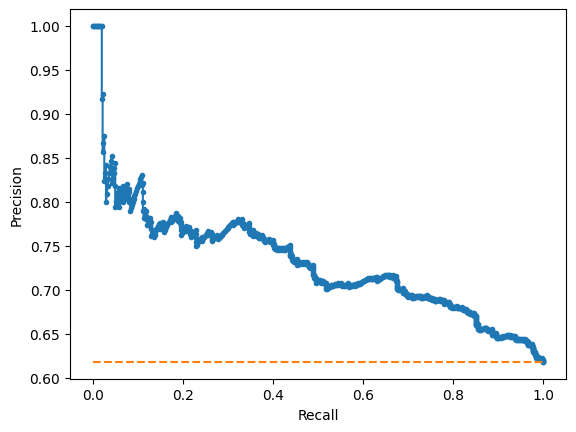

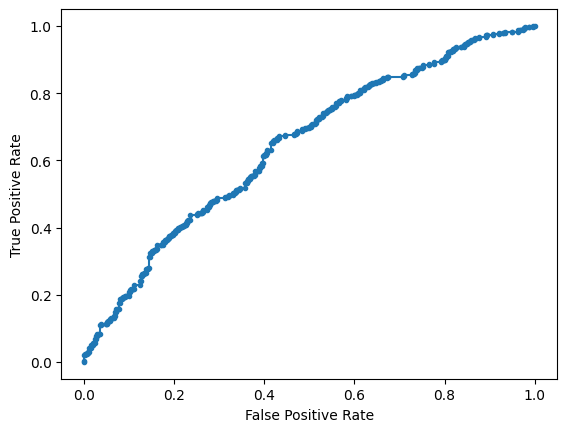

Accuracy: 65.17% Precision: 67.41% Recall: 84.57%
F1: 75.02% MCC: 0.2133
AUPRC: 73.14% AUROC: 64.39%
 accuracy [65.17241379310344]
 precision [67.4074074074074]
 recall [84.5724907063197]
 F1 [75.02061005770815]
 MCC [0.21326440770753136]
 AUPRC [73.13966758842896]
 AUROC [64.39232767501233]
2023-04-04 14:14:53.267770

Training # 1 2
2023-04-04 14:14:53.269244
2023-04-04 14:14:53.269521
Discriminator is GMM
Means [-2.5022412685008932, 0.00565458631949963]
Variances [2.28922828 1.48907794]
Priors [0.42519753 0.57480247]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Train 1:0 2135:1350 61.26%
Computed class weights: {0: 1.2907407407407407, 1: 0.8161592505854801}
Valid 1:0 529:355 59.84%
FIT
2023-04-04 14:14:55.741713


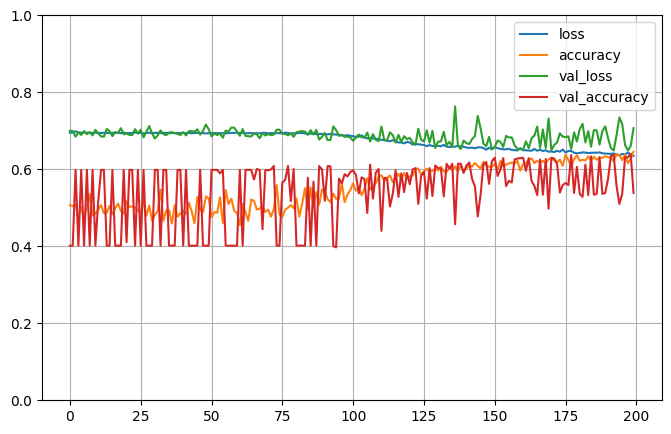


2023-04-04 14:15:50.429816

Testing # 1 2
2023-04-04 14:15:50.431804
2023-04-04 14:15:50.432150
PREDICT
2023-04-04 14:15:50.435872
Test 1:0 529:355 59.84%
Predict 1:0 251:633 28.39%
Test sizes (884, 1025) (884,)
Range of scores: 0.031991404 to 0.9683734
Score threshold 0.5
Confusion matrix
 [[290  65]
 [343 186]]
Normalized matrix
 [[0.3280543  0.07352941]
 [0.38800905 0.21040724]]


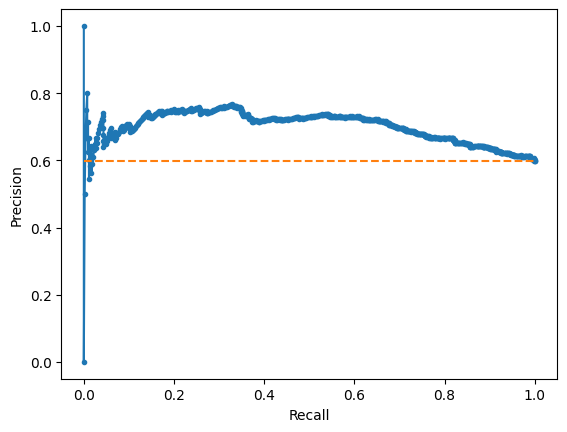

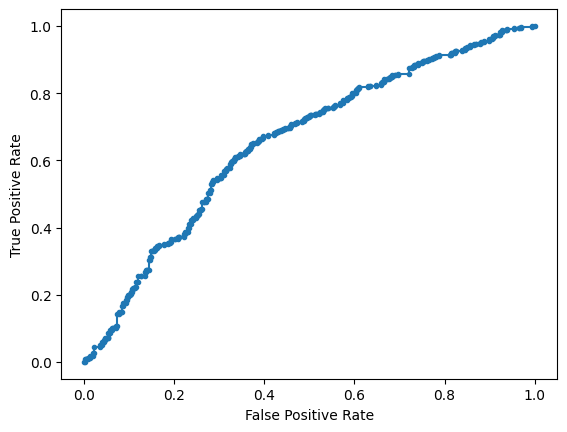

Accuracy: 53.85% Precision: 74.10% Recall: 35.16%
F1: 47.69% MCC: 0.1832
AUPRC: 70.00% AUROC: 65.40%
 accuracy [53.84615384615385]
 precision [74.10358565737052]
 recall [35.16068052930057]
 F1 [47.69230769230769]
 MCC [0.18319953698945599]
 AUPRC [69.99788758143133]
 AUROC [65.40056977022817]
2023-04-04 14:15:50.884216

Training # 1 3
2023-04-04 14:15:50.885914
2023-04-04 14:15:50.885982
Discriminator is GMM
Means [-0.0026252121421639608, -2.489918940535433]
Variances [1.50629361 2.26735568]
Priors [0.57405777 0.42594223]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Train 1:0 2149:1371 61.05%
Computed class weights: {0: 1.2837345003646974, 1: 0.8189855746859004}
Valid 1:0 515:334 60.66%
FIT
2023-04-04 14:15:51.790106


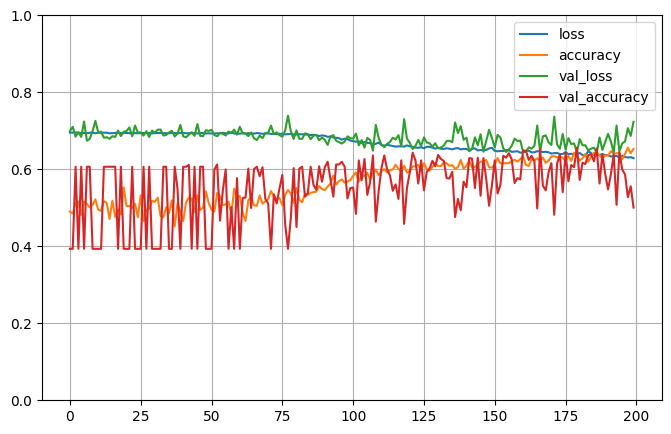


2023-04-04 14:17:14.530807

Testing # 1 3
2023-04-04 14:17:14.532521
2023-04-04 14:17:14.532557
PREDICT
2023-04-04 14:17:14.536498
Test 1:0 515:334 60.66%
Predict 1:0 197:652 23.20%
Test sizes (849, 1025) (849,)
Range of scores: 0.032718815 to 0.9606143
Score threshold 0.5
Confusion matrix
 [[281  53]
 [371 144]]
Normalized matrix
 [[0.33097762 0.06242638]
 [0.43698469 0.16961131]]


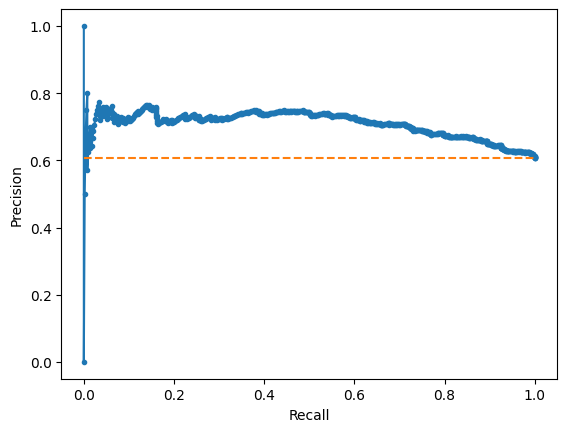

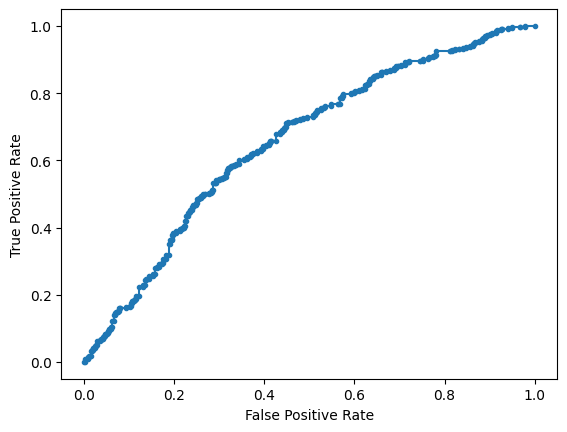

Accuracy: 50.06% Precision: 73.10% Recall: 27.96%
F1: 40.45% MCC: 0.1399
AUPRC: 70.82% AUROC: 65.55%
 accuracy [50.05889281507656]
 precision [73.09644670050761]
 recall [27.96116504854369]
 F1 [40.449438202247194]
 MCC [0.13994276649682175]
 AUPRC [70.82041979175922]
 AUROC [65.54851462124294]
2023-04-04 14:17:14.976698

Training # 1 4
2023-04-04 14:17:14.977933
2023-04-04 14:17:14.978201
Discriminator is GMM
Means [-2.527071518298245, 0.011440000735578097]
Variances [2.19513629 1.4816823 ]
Priors [0.42747628 0.57252372]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Train 1:0 2116:1363 60.82%
Computed class weights: {0: 1.2762289068231842, 1: 0.822069943289225}
Valid 1:0 542:348 60.90%
FIT
2023-04-04 14:17:15.882486


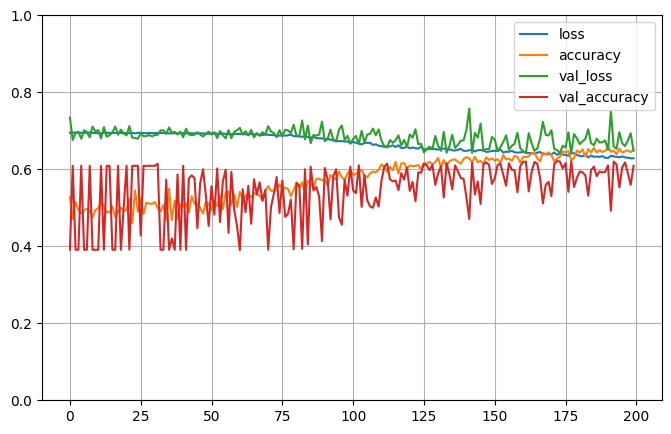


2023-04-04 14:18:10.425929

Testing # 1 4
2023-04-04 14:18:10.426066
2023-04-04 14:18:10.426109
PREDICT
2023-04-04 14:18:10.430056
Test 1:0 542:348 60.90%
Predict 1:0 634:256 71.24%
Test sizes (890, 1025) (890,)
Range of scores: 0.0072830245 to 0.9434595
Score threshold 0.5
Confusion matrix
 [[128 220]
 [128 414]]
Normalized matrix
 [[0.14382022 0.24719101]
 [0.14382022 0.46516854]]


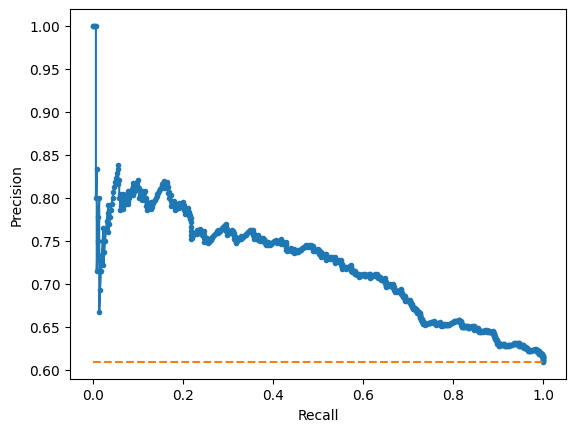

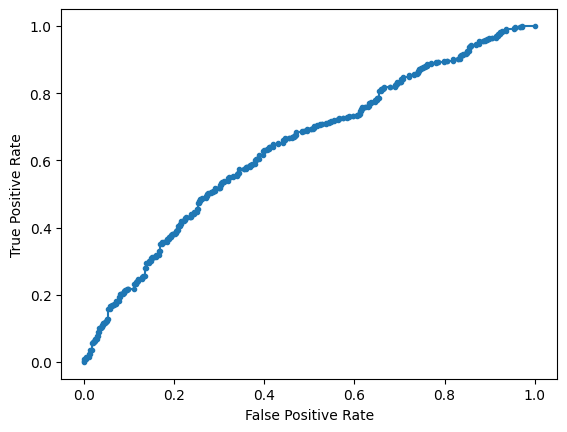

Accuracy: 60.90% Precision: 65.30% Recall: 76.38%
F1: 70.41% MCC: 0.1419
AUPRC: 72.18% AUROC: 64.02%
 accuracy [60.89887640449439]
 precision [65.29968454258676]
 recall [76.38376383763837]
 F1 [70.40816326530613]
 MCC [0.14192464701065874]
 AUPRC [72.18394722389093]
 AUROC [64.02054968825551]
2023-04-04 14:18:10.928504

Training # 1 5
2023-04-04 14:18:10.929996
2023-04-04 14:18:10.930069
Discriminator is GMM
Means [-2.5421860071426576, -0.019981441668219767]
Variances [2.20632461 1.48814443]
Priors [0.42163361 0.57836639]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
Train 1:0 2145:1348 61.41%
Computed class weights: {0: 1.2956231454005935, 1: 0.8142191142191142}
Valid 1:0 552:324 63.01%
FIT
2023-04-04 14:18:13.658373


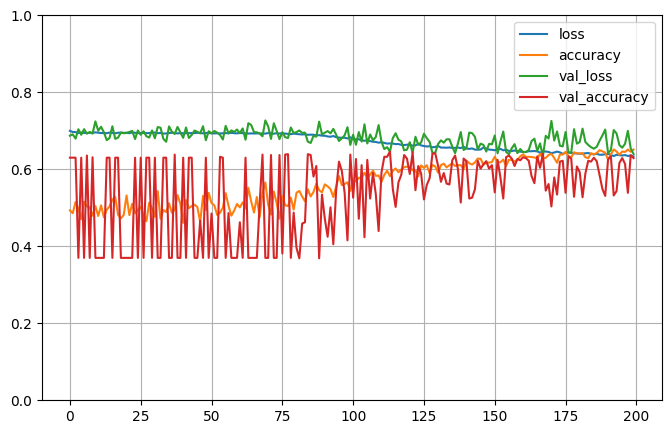


2023-04-04 14:19:10.337787

Testing # 1 5
2023-04-04 14:19:10.341584
2023-04-04 14:19:10.341902
PREDICT
2023-04-04 14:19:10.345582
Test 1:0 552:324 63.01%
Predict 1:0 677:199 77.28%
Test sizes (876, 1025) (876,)
Range of scores: 0.03133458 to 0.9593386
Score threshold 0.5
Confusion matrix
 [[ 99 225]
 [100 452]]
Normalized matrix
 [[0.1130137  0.25684932]
 [0.11415525 0.51598174]]


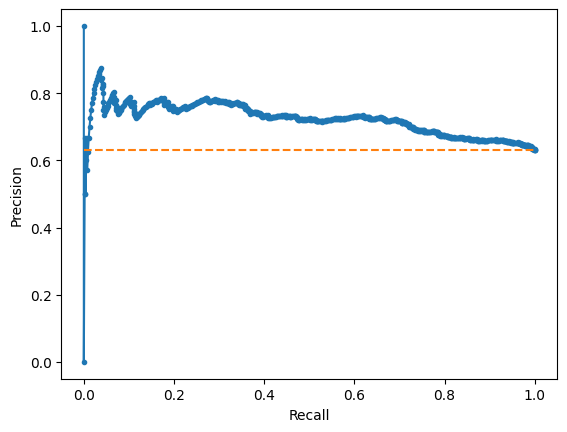

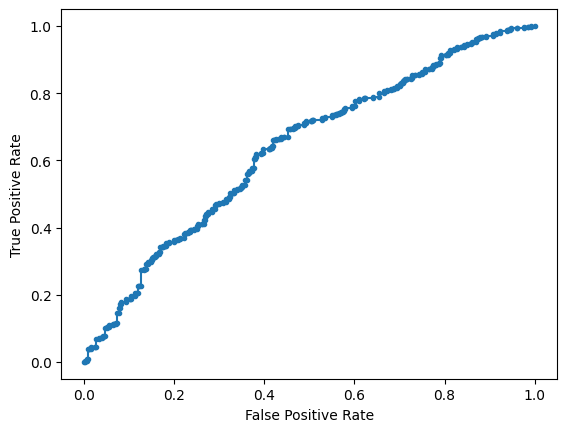

Accuracy: 62.90% Precision: 66.77% Recall: 81.88%
F1: 73.56% MCC: 0.1433
AUPRC: 72.28% AUROC: 63.40%
 accuracy [62.89954337899544]
 precision [66.76514032496307]
 recall [81.88405797101449]
 F1 [73.55573637103336]
 MCC [0.14332701605923043]
 AUPRC [72.27709526793433]
 AUROC [63.40020576131688]
2023-04-04 14:19:10.800722

Training # 2 1
2023-04-04 14:19:10.800948
2023-04-04 14:19:10.801003
Discriminator is GMM
Means [0.007029250118280219, -2.4853421264920206]
Variances [1.44726679 2.21761719]
Priors [0.56111635 0.43888365]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Train 1:0 2068:1414 59.39%
Computed class weights: {0: 1.2312588401697313, 1: 0.8418762088974855}
Valid 1:0 553:334 62.34%
FIT
2023-04-04 14:19:11.745500


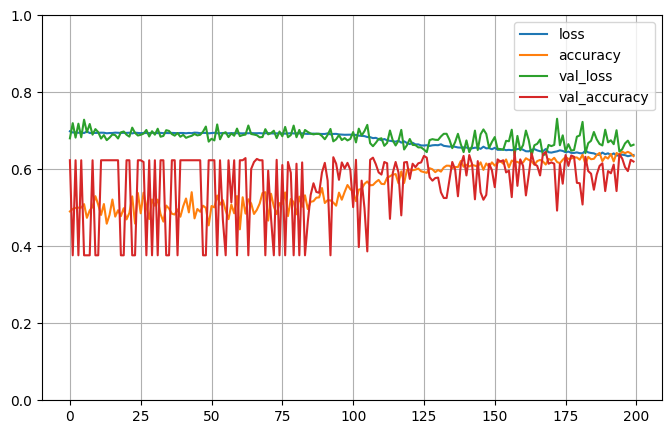


2023-04-04 14:20:08.709328

Testing # 2 1
2023-04-04 14:20:08.710738
2023-04-04 14:20:08.711087
PREDICT
2023-04-04 14:20:08.715718
Test 1:0 553:334 62.34%
Predict 1:0 456:431 51.41%
Test sizes (887, 1025) (887,)
Range of scores: 0.03266476 to 0.96729183
Score threshold 0.5
Confusion matrix
 [[214 120]
 [217 336]]
Normalized matrix
 [[0.24126268 0.13528749]
 [0.24464487 0.37880496]]


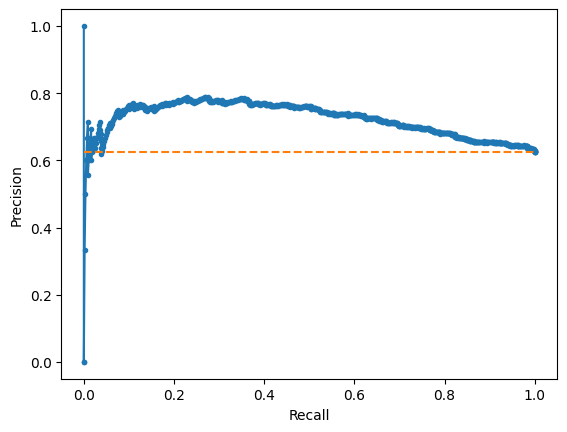

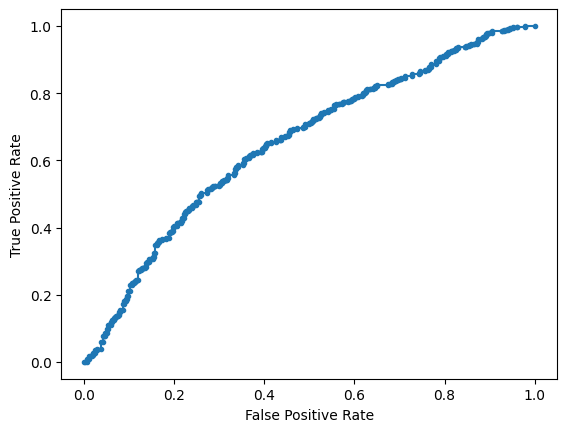

Accuracy: 62.01% Precision: 73.68% Recall: 60.76%
F1: 66.60% MCC: 0.2407
AUPRC: 72.21% AUROC: 65.10%
 accuracy [62.00676437429537]
 precision [73.68421052631578]
 recall [60.75949367088608]
 F1 [66.6005946481665]
 MCC [0.24072160661637373]
 AUPRC [72.21083472702638]
 AUROC [65.0989160918669]
2023-04-04 14:20:09.199773

Training # 2 2
2023-04-04 14:20:09.201366
2023-04-04 14:20:09.201866
Discriminator is GMM
Means [-0.01335649597785484, -2.505546739361269]
Variances [1.48694738 2.21985481]
Priors [0.57675941 0.42324059]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Train 1:0 2153:1348 61.50%
Computed class weights: {0: 1.2985905044510386, 1: 0.8130515559684162}
Valid 1:0 528:340 60.83%
FIT
2023-04-04 14:20:10.120941


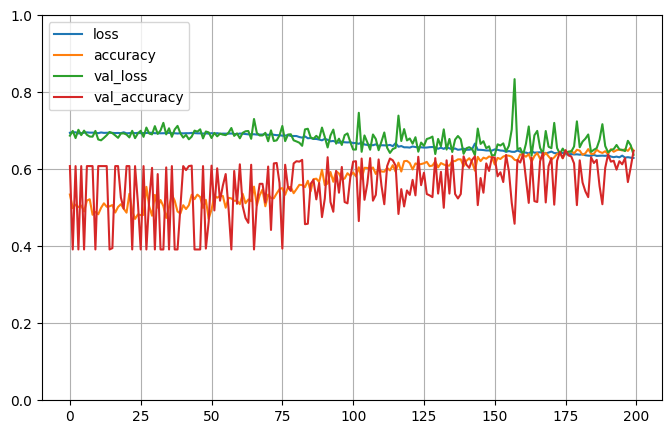


2023-04-04 14:21:06.058731

Testing # 2 2
2023-04-04 14:21:06.058876
2023-04-04 14:21:06.058920
PREDICT
2023-04-04 14:21:06.066063
Test 1:0 528:340 60.83%
Predict 1:0 644:224 74.19%
Test sizes (868, 1025) (868,)
Range of scores: 0.012474206 to 0.9525472
Score threshold 0.5
Confusion matrix
 [[129 211]
 [ 95 433]]
Normalized matrix
 [[0.14861751 0.24308756]
 [0.109447   0.49884793]]


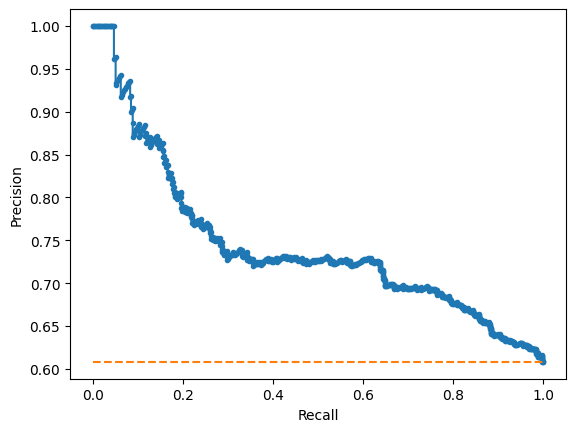

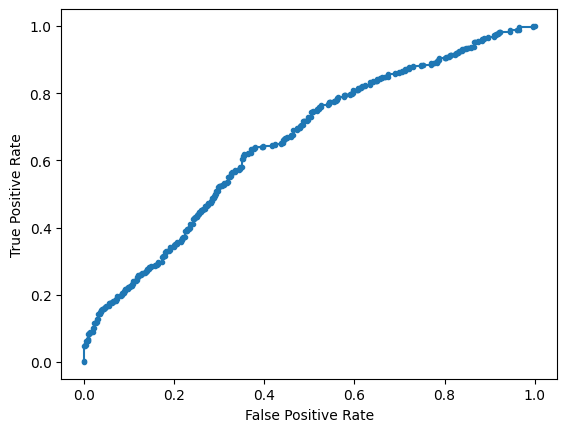

Accuracy: 64.75% Precision: 67.24% Recall: 82.01%
F1: 73.89% MCC: 0.2225
AUPRC: 74.35% AUROC: 65.42%
 accuracy [64.74654377880185]
 precision [67.2360248447205]
 recall [82.00757575757575]
 F1 [73.89078498293516]
 MCC [0.22253852909751115]
 AUPRC [74.34934180274297]
 AUROC [65.42000891265599]
2023-04-04 14:21:06.583040

Training # 2 3
2023-04-04 14:21:06.583705
2023-04-04 14:21:06.583743
Discriminator is GMM
Means [-2.5635275655845584, -0.03781001007016538]
Variances [2.21325292 1.54910884]
Priors [0.41325338 0.58674662]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
Train 1:0 2191:1318 62.44%
Computed class weights: {0: 1.3311836115326252, 1: 0.8007759014148791}
Valid 1:0 537:323 62.44%
FIT
2023-04-04 14:21:07.529236


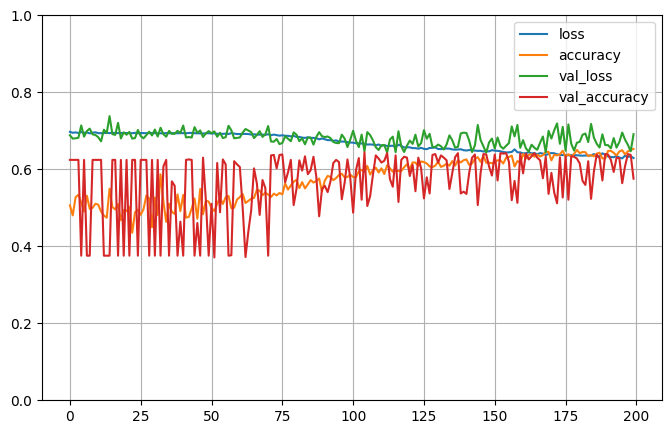


2023-04-04 14:22:30.616342

Testing # 2 3
2023-04-04 14:22:30.616410
2023-04-04 14:22:30.616437
PREDICT
2023-04-04 14:22:30.621935
Test 1:0 537:323 62.44%
Predict 1:0 344:516 40.00%
Test sizes (860, 1025) (860,)
Range of scores: 0.008284788 to 0.9451197
Score threshold 0.5
Confusion matrix
 [[237  86]
 [279 258]]
Normalized matrix
 [[0.2755814 0.1      ]
 [0.3244186 0.3      ]]


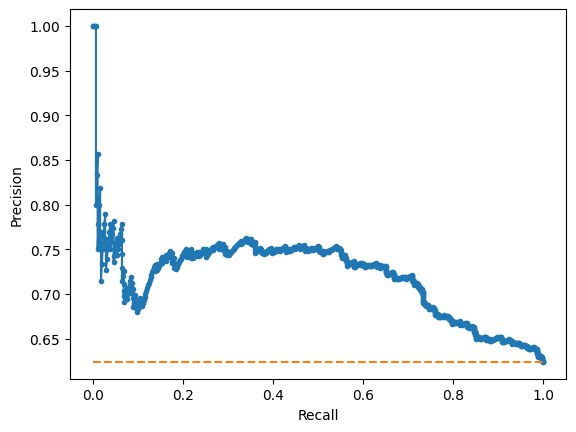

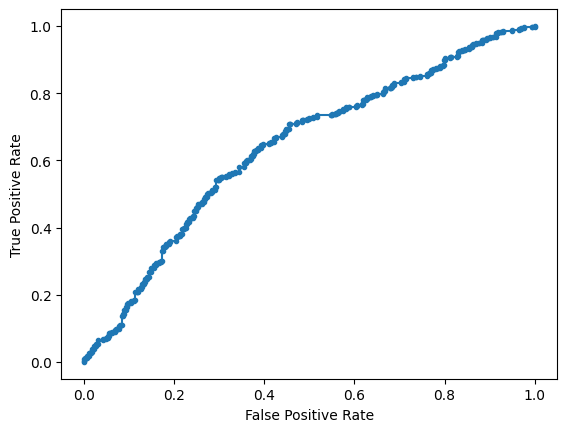

Accuracy: 57.56% Precision: 75.00% Recall: 48.04%
F1: 58.57% MCC: 0.2117
AUPRC: 71.94% AUROC: 63.86%
 accuracy [57.55813953488372]
 precision [75.0]
 recall [48.04469273743017]
 F1 [58.56980703745743]
 MCC [0.2117335708816874]
 AUPRC [71.9377247823556]
 AUROC [63.86183994326928]
2023-04-04 14:22:31.126038

Training # 2 4
2023-04-04 14:22:31.126547
2023-04-04 14:22:31.126579
Discriminator is GMM
Means [0.010236011268788184, -2.5450147661705227]
Variances [1.48776208 2.2463908 ]
Priors [0.58341681 0.41658319]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
Train 1:0 2167:1323 62.09%
Computed class weights: {0: 1.3189720332577475, 1: 0.8052607291185971}
Valid 1:0 528:351 60.07%
FIT
2023-04-04 14:22:32.045560


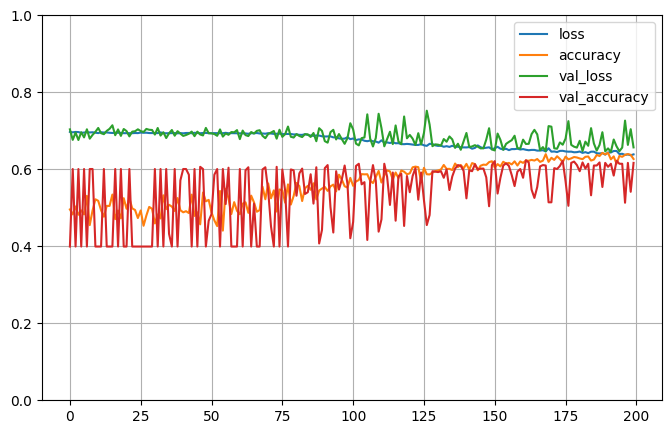


2023-04-04 14:23:28.254815

Testing # 2 4
2023-04-04 14:23:28.255092
2023-04-04 14:23:28.255148
PREDICT
2023-04-04 14:23:28.262146
Test 1:0 528:351 60.07%
Predict 1:0 519:360 59.04%
Test sizes (879, 1025) (879,)
Range of scores: 0.03209313 to 0.91347533
Score threshold 0.5
Confusion matrix
 [[187 164]
 [173 355]]
Normalized matrix
 [[0.21274175 0.18657565]
 [0.19681456 0.40386803]]


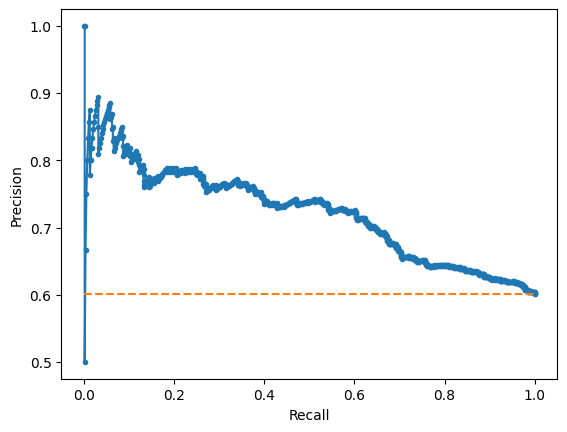

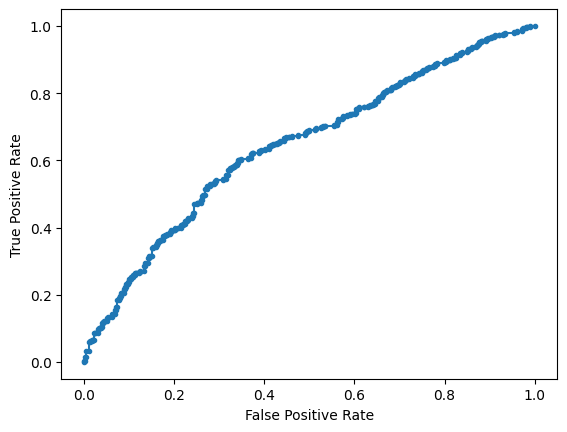

Accuracy: 61.66% Precision: 68.40% Recall: 67.23%
F1: 67.81% MCC: 0.2043
AUPRC: 72.19% AUROC: 64.35%
 accuracy [61.66097838452787]
 precision [68.40077071290945]
 recall [67.23484848484848]
 F1 [67.81279847182427]
 MCC [0.20428039870911396]
 AUPRC [72.18665126422255]
 AUROC [64.34645601312269]
2023-04-04 14:23:28.758501

Training # 2 5
2023-04-04 14:23:28.761952
2023-04-04 14:23:28.762271
Discriminator is GMM
Means [-0.010561725999087078, -2.506592590849554]
Variances [1.51472689 2.1896334 ]
Priors [0.5800219 0.4199781]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
Train 1:0 2161:1333 61.85%
Computed class weights: {0: 1.3105776444111028, 1: 0.8084220268394262}
Valid 1:0 528:347 60.34%
FIT
2023-04-04 14:23:29.702477


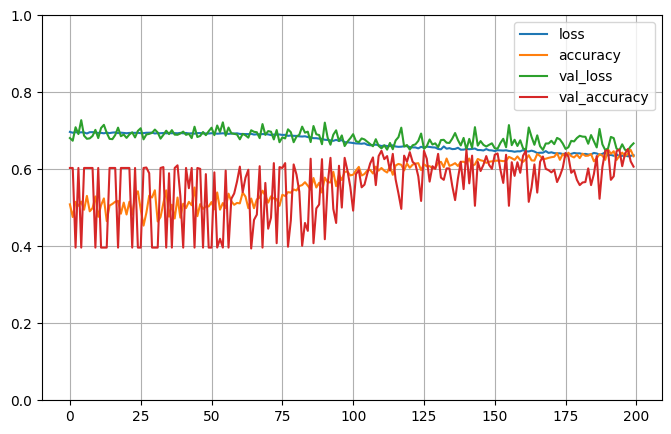


2023-04-04 14:24:52.605666

Testing # 2 5
2023-04-04 14:24:52.607258
2023-04-04 14:24:52.607608
PREDICT
2023-04-04 14:24:52.611439
Test 1:0 528:347 60.34%
Predict 1:0 442:433 50.51%
Test sizes (875, 1025) (875,)
Range of scores: 0.044619847 to 0.97151124
Score threshold 0.5
Confusion matrix
 [[218 129]
 [215 313]]
Normalized matrix
 [[0.24914286 0.14742857]
 [0.24571429 0.35771429]]


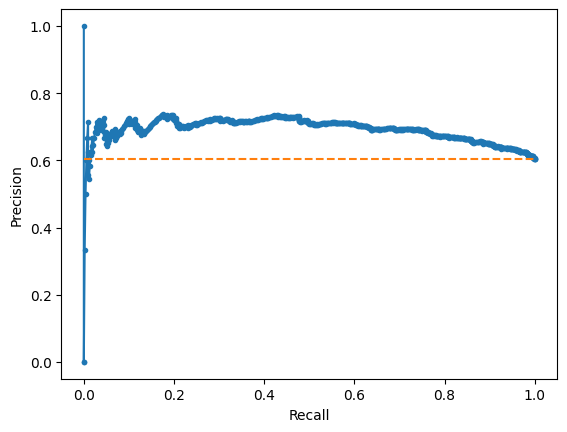

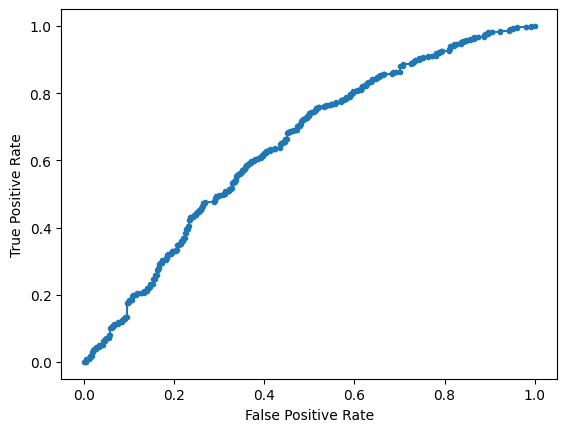

Accuracy: 60.69% Precision: 70.81% Recall: 59.28%
F1: 64.54% MCC: 0.2163
AUPRC: 69.13% AUROC: 64.43%
 accuracy [60.68571428571429]
 precision [70.81447963800905]
 recall [59.28030303030303]
 F1 [64.5360824742268]
 MCC [0.2162755963749853]
 AUPRC [69.12796408822234]
 AUROC [64.43050825255436]
2023-04-04 14:24:53.055264


In [23]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

loader = DataLoader()
filepath = DATA_DIR+RCI_FILE_TRAIN
print("Load RCI from",filepath)
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
filepath = DATA_DIR+SEQ_FILE_TRAIN
print('Load sequence from',filepath)
allids,allseq = loader.load_spectra(filepath)
print('Loaded',len(allseq),'sequences.')
test_gene_to_rci = None
test_allids = None
test_allseq = None
if SEQ_FILE_TEST is not None:
    # Train on the entire train set (no cross-validation).
    # Evaluate with the test files.
    test_loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE_TEST
    print("Load RCI from",filepath)
    test_gene_to_rci = test_loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(test_gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TEST
    print('Load sequence from',filepath)
    test_allids,test_allseq = test_loader.load_spectra(filepath)
    print('Loaded',len(test_allseq),'sequences.')

REPEATS = 2
FOLDS = 5
for repeat in range(REPEATS):
    for fold in range(FOLDS):
        r = repeat+1
        f = fold+1

        if SEQ_FILE_TEST is None:
            # Train on 80% and evaluate on 20%.
            separator = Separator()
            separator.load(DATA_DIR,r,f)
            separator.process(allids,allseq,gene_to_rci)
            train_allids,test_allids = separator.get_ids()
            train_allseq,test_allseq = separator.get_seq()
            train_gene_to_rci,test_gene_to_rci = separator.get_rci()
        else:
            # Train on the entire train set (no cross-validation).
            # Evaluate with the test files.
            train_allids = allids
            train_allseq = allseq
            train_gene_to_rci = gene_to_rci
            test_allids = None
            test_allseq = None
            test_gene_to_rci = None
            
        print(datetime.now())
        print()
        print("Training #",r,f)
        print(datetime.now())
        cvdo = CrossValidator(EPOCHS,BREAK)
        cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
        cvdo.train_new_model(
            train_allids,train_allseq,train_gene_to_rci,
            test_allids,test_allseq,test_gene_to_rci)
           
        print()
        print(datetime.now())
        print()
        print("Testing #",r,f)
        print(datetime.now())
        cvdo.reset_statistics()
        cvdo.test_without_training(
            test_allids,test_allseq,test_gene_to_rci)
        cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
            cvdo.get_statistics()

        print(" accuracy" ,  cv_accuracy)
        print(" precision" , cv_precision)
        print(" recall" ,    cv_recall)
        print(" F1" ,        cv_f1)
        print(" MCC" ,       cv_mcc)
        print(" AUPRC" ,     cv_auprc)
        print(" AUROC" ,     cv_auroc)

        accuracy.append(cv_accuracy)
        precision.append(cv_precision)
        recall.append(cv_recall)
        f1.append(cv_f1)
        mcc.append(cv_mcc)
        auprc.append(cv_auprc)
        auroc.append(cv_auroc)
        if BREAK: break
    if BREAK: break
print(datetime.now())

In [24]:
def STD (values):
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.2f%% std %.2f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 59.95% std 4.81
 precision mean 70.18% std 3.57
 recall mean 62.33% std 20.06
 F1 mean 63.85% std 11.66
 MCC mean 0.19% std 0.04
 AUPRC mean 71.82% std 1.50
 AUROC mean 64.59% std 0.74
 accuracy [[65.17241379310344], [53.84615384615385], [50.05889281507656], [60.89887640449439], [62.89954337899544], [62.00676437429537], [64.74654377880185], [57.55813953488372], [61.66097838452787], [60.68571428571429]]
 precision [[67.4074074074074], [74.10358565737052], [73.09644670050761], [65.29968454258676], [66.76514032496307], [73.68421052631578], [67.2360248447205], [75.0], [68.40077071290945], [70.81447963800905]]
 recall [[84.5724907063197], [35.16068052930057], [27.96116504854369], [76.38376383763837], [81.88405797101449], [60.75949367088608], [82.00757575757575], [48.04469273743017], [67.23484848484848], [59.28030303030303]]
 F1 [[75.02061005770815], [47.69230769230769], [40.449438202247194], [70.40816326530613], [73.55573637103336], [66.6005946481665], [73.89078498293516], [5